In [81]:
# from google.colab import drive
# drive.mount('/content/drive')

In [82]:
# ! pip install pgmpy

In [83]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [84]:
import pandas as pd
import numpy as np

import common

In [85]:
data_set_path = "../temp_sets_100/"

# Patients  

## Data precess

### Read samples

In [86]:
patients_df = common.read_csv_no_rowid(data_set_path+"patients.csv")

In [87]:
admissions_date = common.read_csv_no_rowid(data_set_path+"admissions.csv").loc[:, ['subject_id', 'admittime']]
patients_mid = pd.merge(left=patients_df, right=admissions_date, how='inner', on=['subject_id'])

In [88]:
admissions_date = common.read_csv_no_rowid(data_set_path+"admissions.csv").loc[:, ['subject_id', 'admittime']]
admissions_date.drop_duplicates(subset=['subject_id'], keep='first', inplace=True)
admissions_date['admittime'] = pd.to_datetime(admissions_date['admittime'])

### Drop useless colums

In [89]:
# Drop useless colums
patients_df.drop(['expire_flag', 'dod'], axis=1, inplace=True)

### Deal with null values

In [90]:
# Check null value in table
common.nan_count(patients_df)

Total columns: 5
Total rows: 100
--------------
subject_id     0
gender         0
dob            0
dod_hosp      82
dod_ssn       69
dtype: int64


In [91]:
# Set a value replacing the null time value
nan_datetime=pd.to_datetime(0)

In [92]:
patients_df['dob'].fillna(value=nan_datetime, inplace=True)
# patients_df['dod_hosp'].fillna(value=nan_datetime, inplace=True)
# patients_df['dod_ssn'].fillna(value=nan_datetime, inplace=True)

In [93]:
common.nan_count(patients_df)

Total columns: 5
Total rows: 100
--------------
subject_id     0
gender         0
dob            0
dod_hosp      82
dod_ssn       69
dtype: int64


### Set the column types

In [94]:
patients_df.dtypes

subject_id     int64
gender        object
dob           object
dod_hosp      object
dod_ssn       object
dtype: object

In [95]:
# Transfer some date type

patients_df['dob'] = pd.to_datetime(patients_df['dob'])
patients_df['dod_hosp'] = pd.to_datetime(patients_df['dod_hosp'])
patients_df['dod_ssn'] = pd.to_datetime(patients_df['dod_ssn'])

In [96]:
patients_df.dtypes

subject_id             int64
gender                object
dob           datetime64[ns]
dod_hosp      datetime64[ns]
dod_ssn       datetime64[ns]
dtype: object

### Process dod_hosp and dod_ssn

In [97]:
# patients_df['dod_hosp'] = patients_df['dod_hosp'].apply(lambda x: 1 if pd.isna(x) == False else 0)
# patients_df['dod_ssn'] = patients_df['dod_ssn'].apply(lambda x: 1 if pd.isna(x) == False else 0)

# patients_df['dod_hosp'] = patients_df['dod_hosp'].astype(int)
# patients_df['dod_ssn'] = patients_df['dod_ssn'].astype(int)

In [98]:
# # Define a method to deal with dod_ssn
# def dod_one_hot(df):
#     '''
#     Note that DOD merged together DOD_HOSP and DOD_SSN, giving priority to DOD_HOSP if both were recorded
#     '''
    
#     if (df['dod_hosp'] == 1) and (df['dod_ssn'] == 1):
#         return 0
#     else:
#         return df['dod_ssn']

In [99]:
# patients_df['dod_ssn'] = patients_df.apply(dod_one_hot, axis=1)

### Merge table

In [100]:
patients_df = pd.merge(left=patients_df, right=admissions_date, how='inner', on=['subject_id'])

### Process dob

1. some patients who was rather than 89 years old, whose age were set over 300 years. so I need to try to restore a reasonable random date of birth, to let their age when admitted were reasonable.
2. MIMIC-III has shifted all the date data. I try to shift the `admittime` back to be 2001 - 2012, and accross `addmittime` to reset the birth date

In [101]:
import datetime
import random

def adjust_age_over_90(df):
    years_100 = datetime.timedelta(days = (365 * 100 + 100/4))
    random_days_10_years = datetime.timedelta(days = random.randint(0, 10)*365)
    
    if (df['dob'] - datetime.datetime(1970,1,1)).total_seconds() < 0:
        return (df['admittime'] - years_100 + random_days_10_years)
    else:
        return df['dob']

In [102]:
patients_df['dob'] = patients_df.apply(adjust_age_over_90, axis=1)

In [103]:
# Calculate the age
def get_birth_delta(df):
    return df['admittime'] - df['dob']

# Randomly pick a time between 2001-2012
def adjust_admittime(df):
    return pd.Timestamp(year=random.randint(2001, 2012), \
        month=df['admittime'].month, day=df['admittime'].day)

# Renew the date of birth
def reset_dob(df):
    dob = df['admittime'] - df['dob']
    return pd.to_datetime(dob.date())

In [104]:
patients_df['dob'] = patients_df.apply(get_birth_delta, axis=1)
patients_df['admittime'] = patients_df.apply(adjust_admittime, axis=1)
patients_df['dob'] = patients_df.apply(reset_dob, axis=1)
# patients_df = patients_df.drop(['admittime'], axis=1)

In [105]:
patients_df.drop(['admittime', 'subject_id'], axis=1, inplace=True)

In [106]:
# import datetime
# import random

# def adjust_age_over_90(df):
#     '''
#     This method is to adjust the invalid date in 'dob' (which is 18xx)
#     Process: Plus 300 - 310 years from original date, to let the age of patients are between 90 to 100
#     '''

#     years_100 = datetime.timedelta(days = (365 * 100 + 100/4))
#     random_days_10_years = datetime.timedelta(days = random.randint(0, 10*365))
    
#     # if patient was not dead, give a random reasonable birth
#     if pd.isna(df['dod']):
#         if np.int64(df['dob'].to_numpy()) < 0:
#             return df['dob'] + years_100 + years_100 + years_100 + random_days_10_years
#         else:
#             return df['dob']
#     # if patient was dead, use the death date - random 90 - 100 year, to make sure this patient's age was between 90 to 100
#     else:
#         return df['dod'] - years_100 + random_days_10_years

In [107]:
# from pandas import NaT

# patients_df['dod_hosp'] = patients_df['dod_hosp'].apply(lambda x: 1 if not pd.isna(x) else 0)
# patients_df['dod_ssn'] = patients_df['dod_ssn'].apply(lambda x: 1 if not pd.isna(x) else 0)
# patients_df['dod_live'] = patients_df['dod_live'].apply(lambda x: 1 if not pd.isna(x) else 0)

In [108]:
patients_df.columns

Index(['gender', 'dob', 'dod_hosp', 'dod_ssn'], dtype='object')

---
##  Build Model

In [109]:
from sdv.lite import TabularPreset
from sdv.tabular import GaussianCopula
from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN 
from sdv.tabular import TVAE
from sdv.constraints import FixedCombinations

In [110]:
patients_df.columns

Index(['gender', 'dob', 'dod_hosp', 'dod_ssn'], dtype='object')

### Set constraints

#### Build custom constrains

In [111]:
from sdv.constraints import create_custom_constraint

In [112]:
# # DOD
# def dod_data_unique_is_valid(column_names, data):
#     one = (pd.isna(data['dod']) == False) & (pd.isna(data['dod_hosp']) == False) & (pd.isna(data['dod_ssn']) == True) #& (data['dod'] == data['dod_hosp'])
#     two = (pd.isna(data['dod']) == False) & (pd.isna(data['dod_hosp']) == True) & (pd.isna(data['dod_ssn']) == False) #& (data['dod'] == data['dod_ssn'])
#     three = (pd.isna(data['dod']) == True) & (pd.isna(data['dod_hosp']) == True) & (pd.isna(data['dod_ssn']) == True)
#     is_only = one | two | three
#     return is_only

# def dod_data_unique_trasform(column_names, data):
#     # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
#     return data

# def dod_data_unique_reverse_transform(column_names, transformed_data):
#     # print(transformed_data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])

#     one = (pd.isna(transformed_data['dod']) == False) & (pd.isna(transformed_data['dod_hosp']) == False) & (pd.isna(transformed_data['dod_ssn']) == True)
#     two = (pd.isna(transformed_data['dod']) == False) & (pd.isna(transformed_data['dod_hosp']) == True) & (pd.isna(transformed_data['dod_ssn']) == False)

#     transformed_data['dod_hosp'] = transformed_data[one]['dod']
#     transformed_data['dod_ssn'] = transformed_data[two]['dod']

#     return transformed_data


# DodUniqueProcess = create_custom_constraint(
#     is_valid_fn=dod_data_unique_is_valid,
#     transform_fn=dod_data_unique_trasform,
#     reverse_transform_fn=dod_data_unique_reverse_transform
# )

# dod_data_unique_constraint = DodUniqueProcess(
#     column_names=['dod_hosp', 'dod_ssn']
# )

In [113]:
# # DOB
# def dob_nut_null(column_names, data):
#     return pd.isna(data['dob']) == False

# DobNotNull = create_custom_constraint(
#     is_valid_fn=dob_nut_null
# )

# dob_not_null_constraint = DobNotNull(
#     column_names=['dob']
# )

#### Predefined Constraints

In [114]:
from sdv.constraints import Unique

unique_subject_id_constraint = Unique(
    column_names=['subject_id']
)

In [115]:
# from sdv.constraints import ScalarInequality

# dob_before_2200 = ScalarInequality(
#     column_name='dob',
#     relation='<=',
#     value="2200-01-01"
# )

# dob_after_2000 = ScalarInequality(
#     column_name='dob',
#     relation='>=',
#     value="2000-01-01"
# )

In [116]:
# from sdv.constraints import Inequality

# dob_before_dod = Inequality(
#     low_column_name='dob',
#     high_column_name='dod'
# )

### Build and train model

In [117]:
# constraints = [unique_subject_id_constraint]
constraints = []

In [118]:
train_data = patients_df

In [119]:
best_model = common.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset
Gaussian Copula
CTGAN
CopulaGAN
TVAE
Training finished!
Strat evaluating ...
Evaluating finished!
Gaussian Copula
The best model is: tvae
The ContinuousKL_score is: nan
The DiscreteKL_score is: nan
The total score is: 0.8150755920511669


### Save model

In [120]:
model_save_path = data_set_path + "100_models/" + "patients_model.pkl"
common.save_model(best_model, model_save_path)

---
## Evaluate data

### Generate synthetic data

In [121]:
date_load_path = data_set_path + "100_models/" + "patients_model.pkl"
model = common.load_model(date_load_path)

In [122]:
sample = model.sample(num_rows=len(train_data))

### Evaluation

In [123]:
from sdv.evaluation import evaluate

In [124]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

nan

In [125]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

nan

In [126]:
evaluate(sample, train_data, metrics=['CSTest', 'KSTest', 'ContinuousKLDivergence', 'DiscreteKLDivergence'])

0.9840401807087351

<AxesSubplot:>

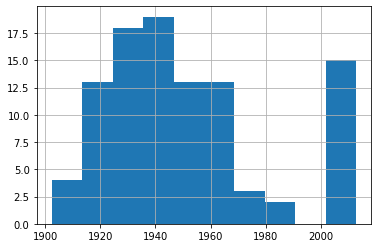

In [127]:
train_data['dob'].hist(bins=10)

<AxesSubplot:>

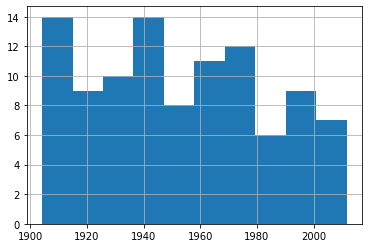

In [128]:
sample['dob'].hist(bins=10)

In [129]:
sample.value_counts()

gender  dob         dod_hosp    dod_ssn   
F       1904-02-27  2155-05-05  2156-01-07    1
        1905-08-13  2149-11-16  2183-04-18    1
        1910-02-27  2153-10-25  2169-05-21    1
        1923-04-12  2151-01-30  2158-06-16    1
        1979-03-20  2168-02-04  2166-07-06    1
M       1913-01-07  2144-07-05  2130-09-15    1
        1918-11-16  2158-05-19  2155-08-12    1
        1946-04-06  2168-01-15  2175-12-27    1
        1955-01-24  2166-03-19  2152-05-25    1
        1962-03-12  2151-04-07  2180-12-03    1
        1976-03-12  2147-03-03  2169-11-15    1
        2000-01-02  2147-10-17  2141-05-17    1
        2001-01-20  2159-01-30  2150-05-12    1
dtype: int64

array([<AxesSubplot:ylabel='gender'>], dtype=object)

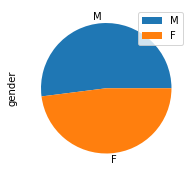

In [130]:
sample['gender'].value_counts().to_frame().plot.pie(subplots=True, figsize=(3,3))

array([<AxesSubplot:ylabel='gender'>], dtype=object)

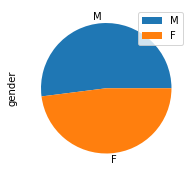

In [131]:
sample['gender'].value_counts().to_frame().plot.pie(subplots=True, figsize=(3,3))

In [132]:
train_data['gender'].value_counts()

M    51
F    49
Name: gender, dtype: int64

---

### Evaluate timeseries data (not accurate in tis table)

In [133]:
from sdv.metrics.timeseries import LSTMDetection, TSFCDetection

In [134]:
metadata_2 = model.get_metadata().to_dict()

In [135]:
metadata_2['entity_columns']=['subject_id']

In [136]:
metadata_2

{'fields': {'gender': {'type': 'categorical',
   'transformer': 'categorical_fuzzy'},
  'dob': {'type': 'datetime', 'transformer': 'datetime'},
  'dod_hosp': {'type': 'datetime', 'transformer': 'datetime'},
  'dod_ssn': {'type': 'datetime', 'transformer': 'datetime'}},
 'constraints': [],
 'model_kwargs': {'GaussianCopula': {'field_distributions': {'gender.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
    'dob.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
    'dod_hosp.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
    'dod_hosp.is_null': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
    'dod_ssn.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
    'dod_ssn.is_null': 'copulas.univariate.truncated_gaussian.TruncatedGaussian'},
   'default_distribution': copulas.univariate.truncated_gaussian.TruncatedGaussian,
   'categorical_transformer': 'categorical_fuzzy'}},
 'name': None,
 'primary_key': Non

In [ ]:
LSTMDetection.compute(sample, train_data, metadata_2)

In [ ]:
patients_df.loc[:, ['subject_id', 'dob']].to_csv(data_set_path + "date_dob.csv", index=0)